In [1]:
#This is not the final output. code runned in golkarnoor.a.d
!pip install rouge
!pip install hazm

In [2]:
import gdown
import time
from sklearn.model_selection import train_test_split

# Define the file URLs
file_urls = [
    "https://drive.google.com/file/d/1xz_YBI8B4fHqAmxlb_3JE5ecJZS5V5z8/view?usp=sharing",
    "https://drive.google.com/file/d/1z9nYQM2wYVQ7zChtShR6ZaHBSxst_UkK/view?usp=sharing",
    "https://drive.google.com/file/d/1--sCAcmSeUiJm0dcqQJNBg1fS-CjC-C4/view?usp=sharing",
    "https://drive.google.com/file/d/1-3DbkWdIjC8BtvqZCQVtZQyrDGNcn4oH/view?usp=sharing"
]

# Download files
for url in file_urls:
    file_id = url.split("/")[5]
    output_file = f"file_{file_id}.zip"  # Customize the output file name if needed
    gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1xz_YBI8B4fHqAmxlb_3JE5ecJZS5V5z8
To: /content/file_1xz_YBI8B4fHqAmxlb_3JE5ecJZS5V5z8.zip
100%|██████████| 271M/271M [00:05<00:00, 52.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1z9nYQM2wYVQ7zChtShR6ZaHBSxst_UkK
To: /content/file_1z9nYQM2wYVQ7zChtShR6ZaHBSxst_UkK.zip
100%|██████████| 18.3M/18.3M [00:00<00:00, 25.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1--sCAcmSeUiJm0dcqQJNBg1fS-CjC-C4
To: /content/file_1--sCAcmSeUiJm0dcqQJNBg1fS-CjC-C4.zip
100%|██████████| 25.9M/25.9M [00:00<00:00, 43.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-3DbkWdIjC8BtvqZCQVtZQyrDGNcn4oH
To: /content/file_1-3DbkWdIjC8BtvqZCQVtZQyrDGNcn4oH.zip
100%|██████████| 96.4M/96.4M [00:01<00:00, 55.1MB/s]


In [3]:
import os
os.rename('/content/file_1z9nYQM2wYVQ7zChtShR6ZaHBSxst_UkK.zip', '/content/test_cleaned.csv')
os.rename('/content/file_1xz_YBI8B4fHqAmxlb_3JE5ecJZS5V5z8.zip', '/content/train_cleaned.csv')
os.rename('/content/file_1--sCAcmSeUiJm0dcqQJNBg1fS-CjC-C4.zip', '/content/word2vec-model.bin')
os.rename('/content/file_1-3DbkWdIjC8BtvqZCQVtZQyrDGNcn4oH.zip', '/content/allInputs.pickle')

In [4]:
import pickle
with open("allInputs.pickle", "rb") as f:
    inputs = pickle.load(f)

In [5]:
padded_inputs = inputs['input1']
padded_targets = inputs['output1']
padded_inputs_test = inputs['input2']
padded_targets_test = inputs['output2']
padded_inputs_valid = inputs['input3']
padded_targets_valid = inputs['output3']
info = inputs['info']

In [6]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, GRU, Dense
from keras.layers import RepeatVector,TimeDistributed

In [7]:
word2vec_model = Word2Vec.load('/content/word2vec-model.bin')

In [8]:
print(info)

[250, 25, 82013, 4755, 838]


In [9]:
word_vectors = word2vec_model.wv
vocab_size = len(word_vectors.key_to_index)
embedding_dim = word2vec_model.vector_size
max_length_input = info[0]
max_length_output = info[1]

In [10]:
special_end_token = '<SPECIAL_END>'
special_end_token_index = len(word_vectors.key_to_index)
special_end_token_vector = np.random.random((embedding_dim,))
word_vectors.add_vectors([special_end_token], [special_end_token_vector])
vocab_size = len(word_vectors.key_to_index)
word_vectors = word2vec_model.wv

In [17]:
def find_end_token(sequence):
    special_end_token_index=15810
    checkingloc = sequence.shape[0] - 1
    if sequence[checkingloc] != 0:
      sequence[checkingloc] = special_end_token_index
      return sequence
    while True:
      checkingloc = checkingloc - 1
      if sequence[checkingloc] != 0:
        sequence[checkingloc+1] = special_end_token_index
        return sequence
      if checkingloc == 0:
        return sequence

In [12]:
special_end_token_index = len(word_vectors.key_to_index) - 1

In [13]:
print(padded_inputs[0])

[  609 10023    61   803  1885   791  8120  1707    75  1208   123  1054
     5    19     4     6  5385  1159    75   123  1054  2158    83   123
    36 14411    75     5    19     4     6   695   823  3528   361     1
  5215   382    72  1013   341   123  1054  3066  8826   171    27   145
    90   402  1499   808   899   692  1931    83   341 10318  2897 10023
  1334  3402  1707   270    83   123  1054     5    32  2721    24    83
   270   141     0   656    83     5    19     4     6    57    83   123
  1054   636   139 11027  7711  2054   276    75   200  3482 14740    24
   459  1623    75    83  1956   649  9113  3000  1129  3556   139  1136
  1085    83   123  1054     5    19     4     6   202     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [ ]:
padded_inputs = np.apply_along_axis(find_end_token, axis=1, arr=padded_inputs)

In [18]:
padded_targets = np.apply_along_axis(find_end_token, axis=1, arr=padded_targets)
padded_inputs_test = np.apply_along_axis(find_end_token, axis=1, arr=padded_inputs_test)
padded_targets_test = np.apply_along_axis(find_end_token, axis=1, arr=padded_targets_test)
padded_inputs_valid = np.apply_along_axis(find_end_token, axis=1, arr=padded_inputs_valid)
padded_targets_valid = np.apply_along_axis(find_end_token, axis=1, arr=padded_targets_valid)

In [21]:
print(padded_inputs[0])

[  609 10023    61   803  1885   791  8120  1707    75  1208   123  1054
     5    19     4     6  5385  1159    75   123  1054  2158    83   123
    36 14411    75     5    19     4     6   695   823  3528   361     1
  5215   382    72  1013   341   123  1054  3066  8826   171    27   145
    90   402  1499   808   899   692  1931    83   341 10318  2897 10023
  1334  3402  1707   270    83   123  1054     5    32  2721    24    83
   270   141     0   656    83     5    19     4     6    57    83   123
  1054   636   139 11027  7711  2054   276    75   200  3482 14740    24
   459  1623    75    83  1956   649  9113  3000  1129  3556   139  1136
  1085    83   123  1054     5    19     4     6   202 15810     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

In [22]:
from keras.layers import RepeatVector, concatenate
from tensorflow.keras.layers import Masking
from tensorflow.keras.layers import Dropout

In [23]:
# article input model
inputs1 = Input(shape=(max_length_input,))
mask1 = Masking(mask_value=0)(inputs1)
article1 = Embedding(vocab_size, embedding_dim, weights=[word2vec_model.wv.vectors], trainable=False)(mask1)
article2 = GRU(200)(article1)
article3 = RepeatVector(max_length_output)(article2)
# summary input model
inputs2 = Input(shape=(max_length_output,))
mask2 = Masking(mask_value=0)(inputs2)
summ1 = Embedding(vocab_size, embedding_dim, weights=[word2vec_model.wv.vectors], trainable=False)(mask2)
# decoder model
decoder1 = concatenate([article3, summ1])
decoder2 = GRU(200)(decoder1)
decoder3 = Dropout(0.1)(decoder2)
outputs = Dense(vocab_size, activation='softmax')(decoder3)
# tie it together [article, summary] [word]
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250)]        0           []                               
                                                                                                  
 masking (Masking)              (None, 250)          0           ['input_1[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 250, 200)     3162200     ['masking[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 25)]         0           []                               
                                                                                              

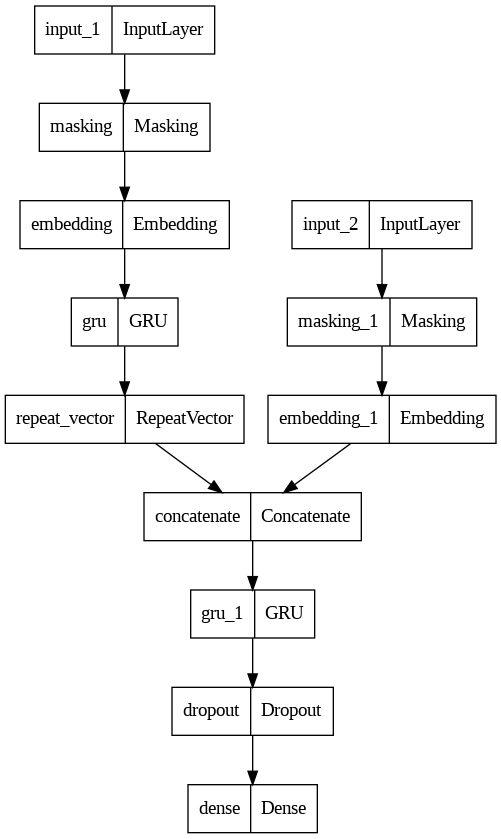

In [25]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [26]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
history_train_loss=[]
history_val_loss=[]
predicts_generated_sofar = pad_sequences([[0]]*82013, maxlen=max_length_output, padding='post')
predicts_generated_sofar_for_valid = pad_sequences([[0]]*838, maxlen=max_length_output, padding='post')

In [30]:
for i in range(13):
    print(f"Fitting for word {i+1}:")
    #Fit:

    #Before:
    #h = model.fit([padded_inputs, predicts_generated_sofar], padded_targets[:, i] , batch_size=64, epochs=7,
    #              validation_data=([padded_inputs_valid,predicts_generated_sofar_for_valid], padded_targets_valid[:, i]))

    #After: Teacher Forcing:
    padded_targets_sliced = pad_sequences(padded_targets[:, :i], maxlen=max_length_output, padding='post')

    h = model.fit([padded_inputs, padded_targets_sliced], padded_targets[:, i], batch_size=64, epochs=7,
                  validation_data=([padded_inputs_valid, predicts_generated_sofar_for_valid], padded_targets_valid[:, i]))
    #Predict: (We don't need this part anymore because we are Teacher forcing with the real output)
    '''
    print(f"Predicting word number {i+1}... and saving it in predicts_generated_sofar")
    batch_size = 5000
    num_samples = padded_inputs.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size
    predicted_summaries = []
    for j in range(num_batches):
        start_idx = j * batch_size
        end_idx = min((j + 1) * batch_size, num_samples)
        batch_inputs = padded_inputs[start_idx:end_idx]
        batch_inputs2 = predicts_generated_sofar[start_idx:end_idx]
        batch_predictions = model.predict([batch_inputs,batch_inputs2], verbose=0)
        batch_predictions[:, 0] = -np.inf
        for x in batch_predictions:
          batch_predicted_indices = np.argmax(x)
          predicted_summaries.append(batch_predicted_indices)
          del batch_predicted_indices
        del batch_inputs, batch_inputs2, batch_predictions,start_idx,end_idx
    time.sleep(1)
    predicts_generated_sofar[:, i] = predicted_summaries
    time.sleep(1)
    del batch_size,num_samples,num_batches,predicted_summaries
    print(f"Predicting word number {i+1} for valid... and saving it in predicts_generated_sofar_valid")
    '''
    #Predict for valid data:
    batch_size = 5000
    num_samples = padded_inputs_valid.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size
    predicted_summaries = []
    for j in range(num_batches):
        start_idx = j * batch_size
        end_idx = min((j + 1) * batch_size, num_samples)
        batch_inputs = padded_inputs_valid[start_idx:end_idx]
        batch_inputs2 = predicts_generated_sofar_for_valid[start_idx:end_idx]
        batch_predictions = model.predict([batch_inputs,batch_inputs2], verbose=0)
        #batch_predictions[:, 0] = -np.inf
        for x in batch_predictions:
          batch_predicted_indices = np.argmax(x)
          predicted_summaries.append(batch_predicted_indices)
          del batch_predicted_indices
        del batch_inputs, batch_inputs2, batch_predictions,start_idx,end_idx
    predicts_generated_sofar_for_valid[:, i] = predicted_summaries
    del batch_size,num_samples,num_batches,predicted_summaries
    #save History
    train_loss = h.history['loss']
    val_loss = h.history['val_loss']
    for x in train_loss:
      history_train_loss.append(x)
    for x in val_loss:
      history_val_loss.append(x)
    del train_loss,h
    del val_loss

Fitting for word 1:
Epoch 1/7
1282/1282 [==============================] - 40s 22ms/step - loss: 6.3741 - accuracy: 0.0602 - val_loss: 6.1076 - val_accuracy: 0.0752
Epoch 2/7
1282/1282 [==============================] - 27s 21ms/step - loss: 5.6849 - accuracy: 0.1646 - val_loss: 5.4100 - val_accuracy: 0.2399
Epoch 3/7
1282/1282 [==============================] - 28s 22ms/step - loss: 5.0851 - accuracy: 0.2818 - val_loss: 5.0315 - val_accuracy: 0.2888
Epoch 4/7
1282/1282 [==============================] - 28s 22ms/step - loss: 4.7378 - accuracy: 0.3217 - val_loss: 4.8260 - val_accuracy: 0.3425
Epoch 5/7
1282/1282 [==============================] - 28s 22ms/step - loss: 4.5047 - accuracy: 0.3419 - val_loss: 4.7283 - val_accuracy: 0.3675
Epoch 6/7
1282/1282 [==============================] - 28s 22ms/step - loss: 4.3279 - accuracy: 0.3544 - val_loss: 4.6991 - val_accuracy: 0.3544
Epoch 7/7
1282/1282 [==============================] - 29s 22ms/step - loss: 4.1635 - accuracy: 0.3671 - val_l

In [31]:
model.save("/content/drive/MyDrive/Recursive_Attention_GRU_TeacherForcing_13words.h5")

In [32]:
predicts_generated_sofar_test = pad_sequences([[0]]*4755, maxlen=max_length_output, padding='post')
#predicts_generated_sofar_test = predicts_generated_sofar_test[:5593]
for i in range(13):
    batch_size = 5000
    num_samples = padded_inputs_test.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size
    predicted_summaries = []
    for j in range(num_batches):
        start_idx = j * batch_size
        end_idx = min((j + 1) * batch_size, num_samples)
        batch_inputs = padded_inputs_test[start_idx:end_idx]
        batch_inputs2 = predicts_generated_sofar_test[start_idx:end_idx]
        batch_predictions = model.predict([batch_inputs,batch_inputs2], verbose=0)
        #batch_predictions[:, 0] = -np.inf
        for x in batch_predictions:
          batch_predicted_indices = np.argmax(x)
          predicted_summaries.append(batch_predicted_indices)
          del batch_predicted_indices
        del batch_inputs, batch_inputs2, batch_predictions,start_idx,end_idx
    predicts_generated_sofar_test[:, i] = predicted_summaries
    print('showing an example of output for row 0:')
    print(predicts_generated_sofar_test[0])
    del batch_size,num_samples,num_batches,predicted_summaries

showing an example of output for row 0:
[379   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0]
showing an example of output for row 0:
[379 199   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0]
showing an example of output for row 0:
[379 199  87   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0]
showing an example of output for row 0:
[ 379  199   87 8038    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
showing an example of output for row 0:
[ 379  199   87 8038 3959    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
showing an example of output for row 0:
[ 379  199   87 8038 3959    4    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
showing an example of output for row 0:
[ 379  199   87 8038 3959  

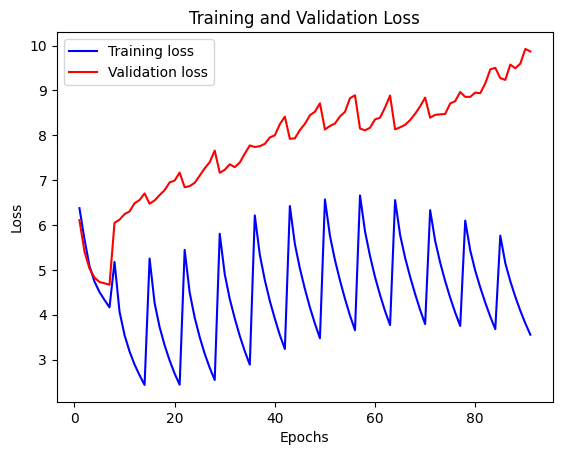

In [33]:
import matplotlib.pyplot as plt
train_loss = history_train_loss
val_loss = history_val_loss
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [34]:
predicted_summary = []
for i in range (len(predicts_generated_sofar_test)):
  predicted_summary.append(' '.join([word_vectors.index_to_key[idx] for idx in predicts_generated_sofar_test[i] if idx != 0]))


In [35]:
from rouge import Rouge

In [36]:
target_summaries = []
for targets in padded_targets_test:
    summary = ' '.join([word2vec_model.wv.index_to_key[idx] for idx in targets if idx != 0])
    target_summaries.append(summary)
# Calculate the ROUGE score
rouge = Rouge()
scores = rouge.get_scores(predicted_summary, target_summaries, avg=True)

#print(scores)

In [37]:
#scores = rouge.get_scores(generated_summaries_words, target_summaries, avg=True)
print("ROUGE Scores:")
print(f"ROUGE-1: {scores['rouge-1']}")
print(f"ROUGE-2: {scores['rouge-2']}")
print(f"ROUGE-L: {scores['rouge-l']}")

ROUGE Scores:
ROUGE-1: {'r': 0.08356922662847699, 'p': 0.34602437520418494, 'f': 0.1246932825662166}
ROUGE-2: {'r': 0.011647856461480144, 'p': 0.035683475888523226, 'f': 0.016660789859856733}
ROUGE-L: {'r': 0.08049175588532356, 'p': 0.33784390396377706, 'f': 0.12038144712614776}


In [38]:
for i in range(13,25):
    print(f"Fitting for word {i+1}:")
    #Fit:

    #Before:
    #h = model.fit([padded_inputs, predicts_generated_sofar], padded_targets[:, i] , batch_size=64, epochs=7,
    #              validation_data=([padded_inputs_valid,predicts_generated_sofar_for_valid], padded_targets_valid[:, i]))

    #After: Teacher Forcing:
    padded_targets_sliced = pad_sequences(padded_targets[:, :i], maxlen=max_length_output, padding='post')

    h = model.fit([padded_inputs, padded_targets_sliced], padded_targets[:, i], batch_size=64, epochs=7,
                  validation_data=([padded_inputs_valid, predicts_generated_sofar_for_valid], padded_targets_valid[:, i]))
    #Predict: (We don't need this part anymore because we are Teacher forcing with the real output)
    '''
    print(f"Predicting word number {i+1}... and saving it in predicts_generated_sofar")
    batch_size = 5000
    num_samples = padded_inputs.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size
    predicted_summaries = []
    for j in range(num_batches):
        start_idx = j * batch_size
        end_idx = min((j + 1) * batch_size, num_samples)
        batch_inputs = padded_inputs[start_idx:end_idx]
        batch_inputs2 = predicts_generated_sofar[start_idx:end_idx]
        batch_predictions = model.predict([batch_inputs,batch_inputs2], verbose=0)
        batch_predictions[:, 0] = -np.inf
        for x in batch_predictions:
          batch_predicted_indices = np.argmax(x)
          predicted_summaries.append(batch_predicted_indices)
          del batch_predicted_indices
        del batch_inputs, batch_inputs2, batch_predictions,start_idx,end_idx
    time.sleep(1)
    predicts_generated_sofar[:, i] = predicted_summaries
    time.sleep(1)
    del batch_size,num_samples,num_batches,predicted_summaries
    print(f"Predicting word number {i+1} for valid... and saving it in predicts_generated_sofar_valid")
    '''
    #Predict for valid data:
    batch_size = 5000
    num_samples = padded_inputs_valid.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size
    predicted_summaries = []
    for j in range(num_batches):
        start_idx = j * batch_size
        end_idx = min((j + 1) * batch_size, num_samples)
        batch_inputs = padded_inputs_valid[start_idx:end_idx]
        batch_inputs2 = predicts_generated_sofar_for_valid[start_idx:end_idx]
        batch_predictions = model.predict([batch_inputs,batch_inputs2], verbose=0)
        #batch_predictions[:, 0] = -np.inf
        for x in batch_predictions:
          batch_predicted_indices = np.argmax(x)
          predicted_summaries.append(batch_predicted_indices)
          del batch_predicted_indices
        del batch_inputs, batch_inputs2, batch_predictions,start_idx,end_idx
    predicts_generated_sofar_for_valid[:, i] = predicted_summaries
    del batch_size,num_samples,num_batches,predicted_summaries
    #save History
    train_loss = h.history['loss']
    val_loss = h.history['val_loss']
    for x in train_loss:
      history_train_loss.append(x)
    for x in val_loss:
      history_val_loss.append(x)
    del train_loss,h
    del val_loss

Fitting for word 14:
Epoch 1/7
1282/1282 [==============================] - 29s 23ms/step - loss: 5.3898 - accuracy: 0.2921 - val_loss: 9.5103 - val_accuracy: 0.0656
Epoch 2/7
1282/1282 [==============================] - 29s 22ms/step - loss: 4.8123 - accuracy: 0.3109 - val_loss: 9.5275 - val_accuracy: 0.0656
Epoch 3/7
1282/1282 [==============================] - 29s 22ms/step - loss: 4.4330 - accuracy: 0.3255 - val_loss: 9.7490 - val_accuracy: 0.0644
Epoch 4/7
1282/1282 [==============================] - 29s 22ms/step - loss: 4.1203 - accuracy: 0.3409 - val_loss: 9.9799 - val_accuracy: 0.0597
Epoch 5/7
1282/1282 [==============================] - 29s 22ms/step - loss: 3.8281 - accuracy: 0.3560 - val_loss: 9.9322 - val_accuracy: 0.0656
Epoch 6/7
1282/1282 [==============================] - 29s 22ms/step - loss: 3.5616 - accuracy: 0.3749 - val_loss: 10.2375 - val_accuracy: 0.0573
Epoch 7/7
1282/1282 [==============================] - 29s 22ms/step - loss: 3.3217 - accuracy: 0.3981 - val

In [39]:
model.save("/content/drive/MyDrive/Recursive_Attention_GRU_TeacherForcing_25words.h5")

In [40]:
predicts_generated_sofar_test = pad_sequences([[0]]*4755, maxlen=max_length_output, padding='post')
#predicts_generated_sofar_test = predicts_generated_sofar_test[:5593]
for i in range(13):
    batch_size = 5000
    num_samples = padded_inputs_test.shape[0]
    num_batches = (num_samples + batch_size - 1) // batch_size
    predicted_summaries = []
    for j in range(num_batches):
        start_idx = j * batch_size
        end_idx = min((j + 1) * batch_size, num_samples)
        batch_inputs = padded_inputs_test[start_idx:end_idx]
        batch_inputs2 = predicts_generated_sofar_test[start_idx:end_idx]
        batch_predictions = model.predict([batch_inputs,batch_inputs2], verbose=0)
        #batch_predictions[:, 0] = -np.inf
        for x in batch_predictions:
          batch_predicted_indices = np.argmax(x)
          predicted_summaries.append(batch_predicted_indices)
          del batch_predicted_indices
        del batch_inputs, batch_inputs2, batch_predictions,start_idx,end_idx
    predicts_generated_sofar_test[:, i] = predicted_summaries
    print('showing an example of output for row 0:')
    print(predicts_generated_sofar_test[0])
    del batch_size,num_samples,num_batches,predicted_summaries

showing an example of output for row 0:
[15810     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0]
showing an example of output for row 0:
[15810     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0]
showing an example of output for row 0:
[15810     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0]
showing an example of output for row 0:
[15810     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0]
showing an example of output for row 0:
[15810     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0]
showing an example of output f

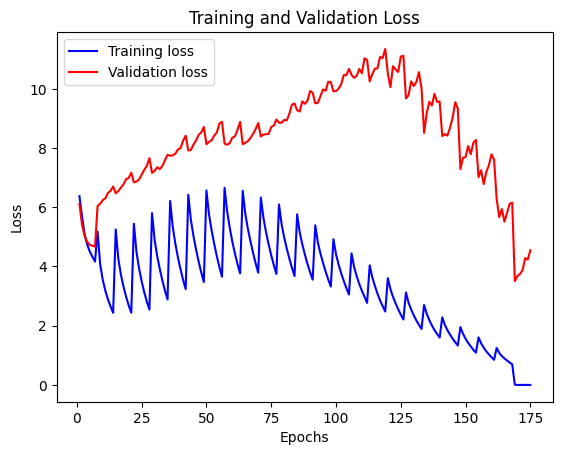

In [41]:
import matplotlib.pyplot as plt
train_loss = history_train_loss
val_loss = history_val_loss
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [42]:
predicted_summary = []
for i in range (len(predicts_generated_sofar_test)):
  predicted_summary.append(' '.join([word_vectors.index_to_key[idx] for idx in predicts_generated_sofar_test[i] if idx != 0]))


In [43]:
from rouge import Rouge

In [44]:
target_summaries = []
for targets in padded_targets_test:
    summary = ' '.join([word2vec_model.wv.index_to_key[idx] for idx in targets if idx != 0])
    target_summaries.append(summary)
# Calculate the ROUGE score
rouge = Rouge()
scores = rouge.get_scores(predicted_summary, target_summaries, avg=True)

#print(scores)

In [45]:
#scores = rouge.get_scores(generated_summaries_words, target_summaries, avg=True)
print("ROUGE Scores:")
print(f"ROUGE-1: {scores['rouge-1']}")
print(f"ROUGE-2: {scores['rouge-2']}")
print(f"ROUGE-L: {scores['rouge-l']}")

ROUGE Scores:
ROUGE-1: {'r': 0.0598372434892652, 'p': 1.0, 'f': 0.11249735743137516}
ROUGE-2: {'r': 0.0, 'p': 0.0, 'f': 0.0}
ROUGE-L: {'r': 0.0598372434892652, 'p': 1.0, 'f': 0.11249735743137516}
